# Latent Vector Clustering

1. 학습한 모델에서 나온 128차원 벡터를 클러스터링할 것이다.
2. 같은 클러스터끼리 동일한 색으로 표시하여 2차원에 나타낼 것이다.
3. 클러스터별 글자 모양을 확인할 것이다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/')

In [ ]:
import numpy as np
import os
import io
import csv
from common.dataset import PickledImageProvider
from common.dataset import KoreanFontDataset
from common.utils import pad_seq, bytes_to_file, \
    read_split_image, shift_and_resize_image, normalize_image, \
    tight_crop_image, add_padding

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from PIL import Image
import os
import os.path

import torch.utils.data
import torchvision.transforms as transforms

def default_image_loader(path):
    return Image.open(path).convert('RGB')

class TripletImageLoader(torch.utils.data.Dataset): 
    def __init__(self, pickled, triplets_file_name, base_path=None, filenames_filename=None, transform=None,
                 loader=default_image_loader):
        """ 
        filenames_filename: 
            A text file with each line containing the path to an image e.g.,
            images/class1/sample.jpg
                
        triplets_file_name: 
            A text file with each line containing three integers, 
            where integer i refers to the i-th image in the filenames file. 
            For a line of intergers 'a b c', a triplet is defined such that image a is more 
            similar to image c than it is to image b, 
            e.g., 0 2017 42 
        """
        self.dset = pickled.examples
#         self.base_path = base_path  
#         self.filenamelist = []
#         for line in open(filenames_filename):
#             self.filenamelist.append(line.rstrip('\n'))
        triplets = []
        anchor_labels = [] #
        for line in open(triplets_file_name):
            triplets.append((line.split()[0], line.split()[1], line.split()[2])) # anchor, far, close
            anchor_labels.append(int(line.split()[3])) #
        self.triplets = triplets
        self.labels = anchor_labels #
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3 = self.triplets[index]
        anchor_label = self.labels[index]
        img1_tuple = self.dset[int(path1)]
        img2_tuple = self.dset[int(path2)]
        img3_tuple = self.dset[int(path3)]
        
        info = {                         # clustering을 위해 anchor_index도 추가하였다.
            'anchor_index': int(path1),
            'anchor_label': anchor_label
        }
        
        # byte만 사용할 예정
        img1, byte_1 = img1_tuple[0], img1_tuple[1]
        img2, byte_2 = img2_tuple[0], img2_tuple[1]
        img3, byte_3 = img3_tuple[0], img3_tuple[1]
        
        # bytes 타입을 numpy array로 변경 후 normalize
        img_arr_1 = np.array(Image.open(io.BytesIO(byte_1)))
        img_arr_1 = normalize_image(img_arr_1)
        
        img_arr_2 = np.array(Image.open(io.BytesIO(byte_2)))
        img_arr_2 = normalize_image(img_arr_2)
        
        img_arr_3 = np.array(Image.open(io.BytesIO(byte_3)))
        img_arr_3 = normalize_image(img_arr_3)

        cropped_image_1, cropped_image_size_1 = tight_crop_image(img_arr_1, verbose=False)
        centered_image_1 = add_padding(cropped_image_1, verbose=False)
        
        cropped_image_2, cropped_image_size_2 = tight_crop_image(img_arr_2, verbose=False)
        centered_image_2 = add_padding(cropped_image_2, verbose=False)
        
        cropped_image_3, cropped_image_size_3 = tight_crop_image(img_arr_3, verbose=False)
        centered_image_3 = add_padding(cropped_image_3, verbose=False)
            
        return (centered_image_1, centered_image_2, centered_image_3), info #

    def __len__(self):
        return len(self.triplets)

In [ ]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_with_label.txt')

In [ ]:
len(triplet_loader[1][0]) # anchor, negative, positive images

3

In [ ]:
triplet_loader[1][1] # anchor label == 0 ( ~ triplet_loader[2349][1])

{'anchor_index': 1776, 'anchor_label': 0}

### 전체 데이터셋 준비

In [ ]:
dset = KoreanFontDataset(PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj'), vector_size=10)

In [ ]:
len(dset)

251450

In [ ]:
dset[0] # 주의) 여기서의 font_index와 TripletLoader의 anchor_label은 다르다.

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 0},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [ ]:
dset[1776] # anchor index 1776의 실제 img

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 482},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

---
## Load Trained Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import shutil
import os
import io

class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

In [ ]:
# FontStyler의 convAE 코드 (layers.py)
class Encoder_conv(nn.Module):
    
    def __init__(self, img_dim=1, conv_dim=16): # output dim은 128이 될 것
        super(Encoder_conv, self).__init__()
        self.conv1 = conv2d(img_dim, conv_dim, k_size=5, stride=2, pad=2, dilation=2, lrelu=False, bn=False)
        self.conv2 = conv2d(conv_dim, conv_dim*2, k_size=5, stride=4, pad=2, dilation=2)
        self.conv3 = conv2d(conv_dim*2, conv_dim*4, k_size=4, stride=4, pad=1, dilation=1)
        self.conv4 = conv2d(conv_dim*4, conv_dim*8)
        self.conv5 = conv2d(conv_dim*8, conv_dim*8)
    
    def forward(self, images):
        # |images| = (batch, img, img)
        # print(images.shape)
        images = images.unsqueeze(dim=1)
        # |images| = (batch, 1, 128, 128)
        # print(images.shape)
        e1 = self.conv1(images)
        # |e1| = (batch, conv_dim, 64, 64)
        # print(e1.shape)
        e2 = self.conv2(e1)
        # |e2| = (batch, conv_dim*2, 16, 16)
        # print(e2.shape)
        e3 = self.conv3(e2)
        # |e3| = (batch, conv_dim*4, 4, 4)
        # print(e3.shape)
        e4 = self.conv4(e3)
        # |e4| = (batch, conv_dim*8, 2, 2)
        # print(e4.shape)
        encoded_source = self.conv5(e4)
        # |encoded_source| = (batch, conv_dim*8, 1, 1)
        # print(encoded_source.shape)
        
        return encoded_source

In [ ]:
# function.py
import torch.nn as nn

def batch_norm(c_out, momentum=0.1):
    return nn.BatchNorm2d(c_out, momentum=momentum)

def conv2d(c_in, c_out, k_size=3, stride=2, pad=1, dilation=1, bn=True, lrelu=True, leak=0.2):
    layers = []
    if lrelu:
        layers.append(nn.LeakyReLU(leak))
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def deconv2d(c_in, c_out, k_size=3, stride=1, pad=1, dilation=1, bn=True, dropout=False, p=0.5):
    layers = []
    layers.append(nn.LeakyReLU(0.2))
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    if dropout:
        layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)

def lrelu(leak=0.2):
    return nn.LeakyReLU(leak)

def dropout(p=0.2):
    return nn.Dropout(p)

In [ ]:
checkpoint_pth = '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/runs/TripleNet/model_best.pth.tar'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best = torch.load(checkpoint_pth)

# 학습된 TripletNet 로드
model = Encoder_conv()
tnet  = Tripletnet(model)
tnet.load_state_dict(best['state_dict'])

<All keys matched successfully>

In [ ]:
tnet.cuda()

Tripletnet(
  (embeddingnet): Encoder_conv(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    )
    (conv2): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv4): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv5): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2)

In [ ]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_with_label.txt')

In [ ]:
len(triplet_loader)

251450

In [ ]:
triplet_loader[2350][1] # label이 출력되는지 확인

{'anchor_index': 42952, 'anchor_label': 1}

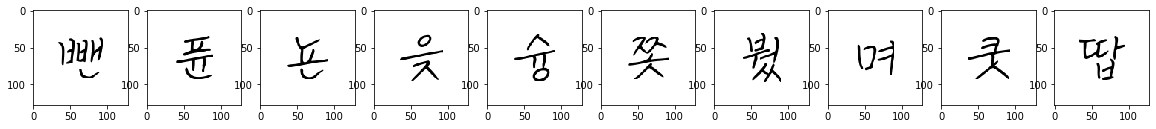

In [ ]:
# anchor (이 이미지들을 Triplet network에 통과시켜 plotting할 것이다.)
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader[idx+5000][0][0], cmap='gray', label=idx)
plt.show()

---
## Make Latent Vectors

In [ ]:
dset[1273]

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 2143},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [ ]:
triplet_loader[0]

((array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]])),
 {'anchor_index': 1273, 'anchor_label': 0})

In [ ]:
print(dset[0][1].shape)
print(triplet_loader[0][0][0].shape)

(128, 128)
(128, 128)


# K-means clustering
메모리상의 문제로 50000개만 테스트

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

idxs = list(range(len(triplet_loader)))
np.random.shuffle(idxs)
batch_size = 32

sampler = SubsetRandomSampler(idxs) # 전체 샘플링
loader = torch.utils.data.DataLoader(
        triplet_loader,
        batch_size = batch_size,
        sampler = sampler
    )

In [ ]:
tnet.eval()
with torch.no_grad():
    anchors = []
    labels  = []
    indexes = []
    for idx, ((img1, img2, img3), info) in enumerate(loader): 
        if device == 'cuda':
            img1, img2, img3 = img1.cuda(), img2.cuda(), img3.cuda()
        img1, img2, img3 = img1.float(), img2.float(), img3.float()

        _, _, anchor, _, _ = tnet(img1, img2, img3)
        anchors.append(anchor) 
        labels.append(info['anchor_label'])
        indexes.append(info['anchor_index'])
        # if idx == 1000:
        #     break

In [ ]:
len(anchors), len(labels), len(indexes)

(7858, 7858, 7858)

In [ ]:
anchors[0].shape

torch.Size([32, 128, 1, 1])

In [ ]:
latent = np.zeros((1, 128, 1, 1))
for i in range(len(anchors)):
    latent = np.concatenate([latent, anchors[i].cpu()])
latent = latent[1:]
print('latent shape: {}'.format(latent.shape))

tmp_label = np.zeros((1))
for i in range(len(labels)):
    tmp_label = np.concatenate([tmp_label, labels[i].cpu()])
tmp_label = tmp_label[1:]
print('label shape: {}'.format(tmp_label.shape))

tmp_index = np.zeros((1))
for i in range(len(indexes)):
    tmp_index = np.concatenate([tmp_index, indexes[i].cpu()])
tmp_index = tmp_index[1:]
print('index shape: {}'.format(tmp_index.shape))

latent shape: (251450, 128, 1, 1)
label shape: (251450,)
index shape: (251450,)


In [ ]:
tmp_label[0], tmp_index[0] # dset[116740]과 대응

(2.0, 69096.0)

In [ ]:
latent = latent.reshape(251450,128)
latent.shape

(251450, 128)

In [ ]:
latent[0], tmp_index[0]

(array([ 0.06715689, -0.05768156, -0.00412684, -0.11365774,  0.00564228,
        -0.12406905, -0.05142889,  0.05743443,  0.09971364,  0.01493433,
        -0.00884482, -0.08293482, -0.04955475,  0.01091369,  0.00503379,
         0.01716181,  0.00556268, -0.00960979, -0.02602595,  0.03764322,
        -0.0227161 ,  0.0430159 , -0.04669191,  0.00834034,  0.01048747,
        -0.00459874,  0.07823171, -0.00161625,  0.0584276 , -0.0078498 ,
         0.03145668,  0.05510917, -0.01737026,  0.00082929, -0.02661196,
        -0.11266394, -0.08947451, -0.02035593,  0.0057288 , -0.02367881,
         0.03945861,  0.05679487,  0.01551635, -0.05154809, -0.15161981,
         0.01303685,  0.04867334,  0.04642671, -0.00109911, -0.04089551,
        -0.00973028,  0.04226191,  0.0060075 , -0.06047244, -0.01485223,
         0.00285084,  0.00699041, -0.05667721,  0.01423659, -0.04967143,
        -0.00694296,  0.00784096, -0.02635893, -0.0460146 ,  0.10419799,
        -0.01734038, -0.02719552, -0.16383737, -0.0

### Elbow Point 확인

Text(0.5, 1.0, 'Elbow curve')

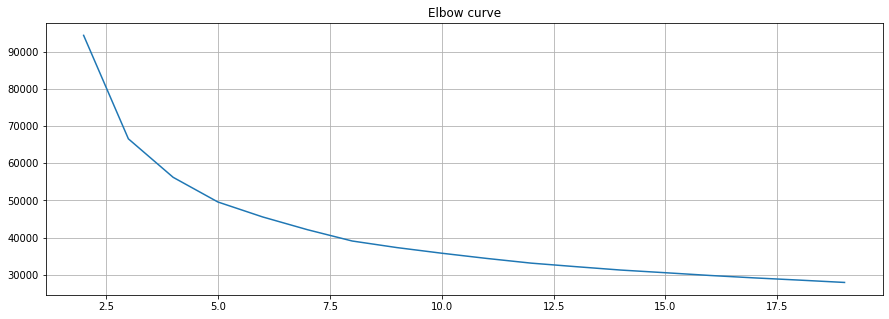

In [ ]:
X = latent
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15,5))
plt.plot(range(2,20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

k = 5 정도가 괜찮아 보인다.

In [ ]:
model = KMeans(n_clusters=5)
model.fit(latent)

y_predict = model.fit_predict(latent)

In [ ]:
print(y_predict[:100])

[0 0 1 4 1 4 2 4 3 4 0 4 1 4 4 1 3 1 4 0 1 1 2 4 2 0 2 2 4 1 0 1 3 2 4 1 0
 1 2 2 4 0 3 4 3 2 2 3 1 2 4 1 0 1 4 1 4 1 4 2 1 2 1 1 4 2 3 4 4 2 1 2 0 1
 2 4 2 4 2 4 4 3 2 3 4 0 2 1 2 2 0 3 2 1 1 3 1 1 2 1]


In [ ]:
colors = {0:'red', 1:'blue', 2: 'yellow', 3: 'pink' , 4:'green'}

In [ ]:
[np.sum(y_predict==i) for i in range(5)]

[39654, 73993, 58224, 27795, 51784]

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# cluster 0
plt.figure(figsize=(10, 10))
s = 0
count = 0
cluster = 0

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        # print(idx)
        plt.subplot(5,5, s+1)                # (5,5)에 s+1번째에 그림을 그려라
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
        if s % 25 == 0: 
            filename = '{}_{}'.format(cluster, count) 
            count += 1
            plt.savefig('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster/{}/{}'.format(cluster, filename), bbox_inches='tight')
            # print('saved img')
            s = 0
        if count == 100:
            break
print('saved {} images for cluster {}'.format(count, cluster))
plt.show()
plt.close()

In [ ]:
# cluster 1
plt.figure(figsize=(10, 10))
s = 0
count = 0
cluster = 1

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        # print(idx)
        plt.subplot(5,5, s+1)                # (5,5)에 s+1번째에 그림을 그려라
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
        if s % 25 == 0: 
            filename = '{}_{}'.format(cluster, count)
            count += 1
            plt.savefig('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster/{}/{}'.format(cluster, filename), bbox_inches='tight')
            # print('saved img')
            s = 0
        if count == 100:
            break
print('saved {} images for cluster {}'.format(count, cluster))
plt.show()
plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


saved 100 images for cluster 2


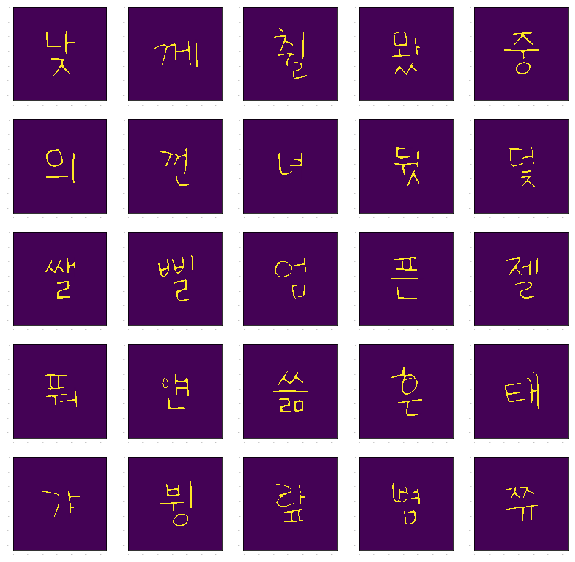

In [ ]:
# cluster 2
plt.figure(figsize=(10, 10))
s = 0
count = 0
cluster = 2

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        # print(idx)
        plt.subplot(5,5, s+1)                # (5,5)에 s+1번째에 그림을 그려라
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
        if s % 25 == 0: 
            filename = '{}_{}'.format(cluster, count)
            count += 1
            plt.savefig('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster/{}/{}'.format(cluster, filename), bbox_inches='tight')
            # print('saved img')
            s = 0
        if count == 100:
            break
print('saved {} images for cluster {}'.format(count, cluster))
plt.show()
plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


saved 100 images for cluster 3


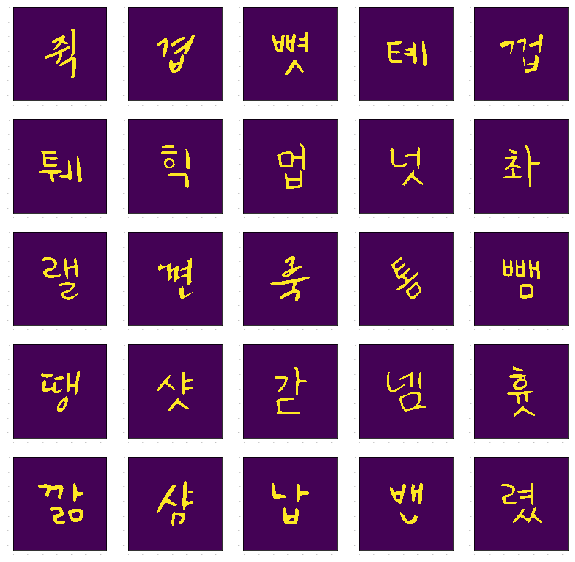

In [ ]:
# cluster 3
plt.figure(figsize=(10, 10))
s = 0
count = 0
cluster = 3

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        # print(idx)
        plt.subplot(5,5, s+1)                # (5,5)에 s+1번째에 그림을 그려라
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
        if s % 25 == 0: 
            filename = '{}_{}'.format(cluster, count)
            count += 1
            plt.savefig('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster/{}/{}'.format(cluster, filename), bbox_inches='tight')
            # print('saved img')
            s = 0
        if count == 100:
            break
print('saved {} images for cluster {}'.format(count, cluster))
plt.show()
plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


saved 100 images for cluster 4


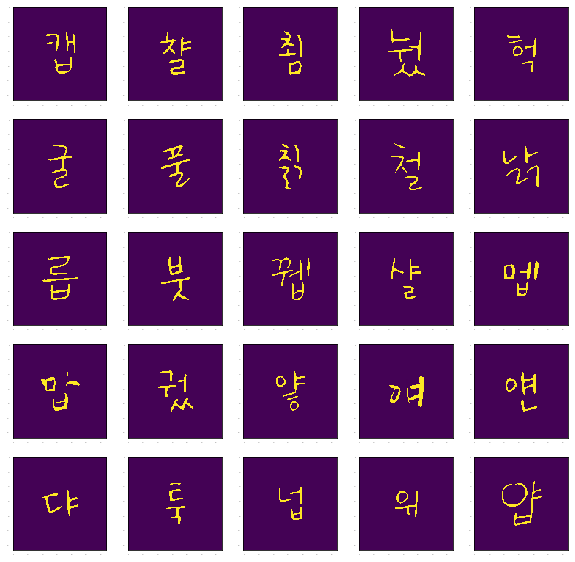

In [ ]:
# cluster 4
plt.figure(figsize=(10, 10))
s = 0
count = 0
cluster = 4

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        # print(idx)
        plt.subplot(5,5, s+1)                # (5,5)에 s+1번째에 그림을 그려라
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
        if s % 25 == 0: 
            filename = '{}_{}'.format(cluster, count)
            count += 1
            plt.savefig('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster/{}/{}'.format(cluster, filename), bbox_inches='tight')
            # print('saved img')
            s = 0
        if count == 100:
            break
print('saved {} images for cluster {}'.format(count, cluster))
plt.show()
plt.close()

---
## Cluster별 latent vector의 평균 구하기

In [ ]:
# cluster 0
count = 0
cluster = 0
vector_size = 128
vectors = np.zeros(vector_size,)

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        vectors += latent[int(idx)]
        count += 1
avg_vector_0 = vectors / count
print('average vector for cluster {} with {} data'.format(cluster, count))

average vector for cluster 0 with 39654 data


In [ ]:
# cluster 1
count = 0
cluster = 1
vector_size = 128
vectors = np.zeros(vector_size,)

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        vectors += latent[int(idx)]
        count += 1
avg_vector_1 = vectors / count
print('average vector for cluster {} with {} data'.format(cluster, count))

average vector for cluster 1 with 73993 data


In [ ]:
# cluster 2
count = 0
cluster = 2
vector_size = 128
vectors = np.zeros(vector_size,)

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        vectors += latent[int(idx)]
        count += 1
avg_vector_2 = vectors / count
print('average vector for cluster {} with {} data'.format(cluster, count))

average vector for cluster 2 with 58224 data


In [ ]:
# cluster 3
count = 0
cluster = 3
vector_size = 128
vectors = np.zeros(vector_size,)

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        vectors += latent[int(idx)]
        count += 1
avg_vector_3 = vectors / count
print('average vector for cluster {} with {} data'.format(cluster, count))

average vector for cluster 3 with 27795 data


In [ ]:
# cluster 4
count = 0
cluster = 4
vector_size = 128
vectors = np.zeros(vector_size,)

for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c == cluster:
        vectors += latent[int(idx)]
        count += 1
avg_vector_4 = vectors / count
print('average vector for cluster {} with {} data'.format(cluster, count))

average vector for cluster 4 with 51784 data


In [ ]:
cluster_vector = {
    0: avg_vector_0,
    1: avg_vector_1,
    2: avg_vector_2,
    3: avg_vector_3,
    4: avg_vector_4,
}

### 딕셔너리를 pickle로 저장

In [ ]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster_vector.p', 'wb') as file:
    pickle.dump(cluster_vector, file)

In [ ]:
# 확인
with open('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/cluster_vector.p', 'rb') as file:
    vec_test = pickle.load(file)
    print(len(vec_test))

5
